<div style="font-family: Arial; text-align: center;">

## Logistic Regression
#### Kannan Singaravelu, CQF

##  <strong>  Logistic Regression

Logistic Regression is one of the most widely used algorithms for classification that maps quantitative
data onto categorial variables. Unlike Linear Regression, where y is an outcome variable, we use a
function of y called the logit.
Logit can be modelled as a linear function of the predictor

$$Logit = log(odds) = w_0 + w_1x_1 + w_2x_2 + .... + w_qx_q$$

and can be mapped back to a probability which in turn can be mapped to a class.

***Problem Statement***

Objective is to predict the underlying trend based on classification algorithm and formulate a trading
strategy. In this lab, we’ll use Logistic Regression to predict market direction and devise a trading
strategies and analyse the results.

Import Libraries


In [1]:
!pip install functools

  Using cached functools-0.5.tar.gz (4.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for functools
Failed to build functools


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [1 lines of output]
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
ERROR: Could not build wheels for functools, which is required to install pyproject.toml-based projects


In [2]:
# Base Libraries
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
# Classifier
from sklearn.linear_model import LogisticRegression
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
1
from sklearn.model_selection import (
train_test_split,
TimeSeriesSplit
)
# Metrics
from sklearn.metrics import (
accuracy_score,
classification_report,
RocCurveDisplay,
ConfusionMatrixDisplay,
log_loss
)


#  <strong> 1 Collect & Load Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv', index_col=0, parse_dates=True,dayfirst=True)
df.head(3)

Open     High      Low    Close     Volume
2012-01-02  4640.20  4645.95  4588.05  4636.75  108461000
2012-01-03  4675.80  4773.10  4675.80  4765.30  146621008
2012-01-04  4774.95  4782.85  4728.85  4749.65  165939008

In [4]:
#df = pd.read_csv('../data/niftyindex.csv', index_col=0, parse_dates=True,dayfirst=True)
#df.head(2)

In [5]:
# Get Info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5 KB


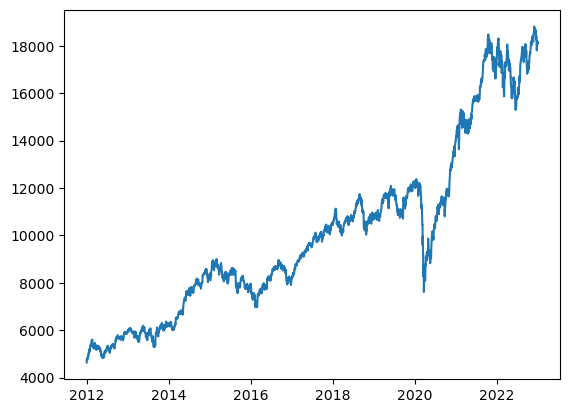

In [6]:
# Visualize data
plt.plot(df['Close']);


#  <strong> 2 EDA of Original dataset </strong>

In [7]:
# Descriptive statistics
df.describe().T

count          mean           std         min           25%  \
Open    2719.0  1.012490e+04  3.709607e+03     4640.20  7.637000e+03   
High    2719.0  1.017529e+04  3.725527e+03     4645.95  7.681000e+03   
Low     2719.0  1.005747e+04  3.685305e+03     4588.05  7.581650e+03   
Close   2719.0  1.011757e+04  3.706945e+03     4636.75  7.623800e+03   
Volume  2719.0  2.892221e+08  1.952768e+08  2826000.00  1.591780e+08   

                 50%           75%           max  
Open    9.376950e+03  1.170085e+04  1.887195e+04  
High    9.431900e+03  1.175512e+04  1.888760e+04  
Low     9.301350e+03  1.163133e+04  1.877820e+04  
Close   9.351850e+03  1.168400e+04  1.881250e+04  
Volume  2.194961e+08  3.409088e+08  1.810971e+09

#  <strong> 3 EDA of Original dataset </strong>
Data is already cleaned. No further processing or imputation required.


In [8]:
 # Check for missing values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#  <strong> 4  Feature Engineering </strong>
Features or Predictors are also known as an independent variable which are used to determine the
value of the target variable. We will derive a features set from the original dataset.

##  <strong> 4.1  Feature Specification  </strong>

In [9]:
# Create Features
df['HC'] = df['High'] - df['Close']
df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
df['MA7'] = df['Close'] / df['Close'].rolling(7).mean()
df['VMA'] = df['Volume'] / df['Volume'].rolling(7).mean()
df['OC_'] = df['Close'] / df['Open'] - 1
df['OC'] = df['OC_'].rolling(7).mean()
df['OC'] = df['OC_'].rolling(14).mean()
df['HC_'] = df['High'] / df['Low'] - 1
df['HC'] = df['HC_'].rolling(7).mean()
df['GAP_'] = df['Open'] / df['Close'].shift(1) - 1
df['GAP'] = df['GAP_'].rolling(7).mean()
df['STD'] = df['RET'].rolling(7).std()
df['UB'] = df['Close'].rolling(7).mean() + df['Close'].rolling(7).std() * 2
df.dropna(inplace=True)
features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'OC_', 'HC_','GAP_'], axis=1)
features.head(2)

HC       RET       MA7       VMA        OC       GAP  \
2012-01-19  0.010942  0.012553  1.021970  1.002220  0.003754  0.002402   
2012-01-20  0.011600  0.006000  1.022538  1.079615  0.003860  0.002754   

                 STD           UB  
2012-01-19  0.008689  5049.501848  
2012-01-20  0.008620  5101.753784

In [10]:
# Specific X
X = features.values

##  <strong> 4.2 Label Specification   </strong>

Label or the target variable is also known as the dependent variable. Here, the target variable is
whether the underlying price will close up or down on the next trading day. If the tomorrow’s
closing price is greater than the 0.995 of today’s closing price, then we will buy the underlying, else
we will sell it.
We assign a value of +1 for the buy signal and 0 otherwise. The target can be described as :

$$y_t = \left\lbrace \begin{align}
+1 & \quad p_{t+1}> 0.995 p_t\\
-1 & \quad \text{otherwise}
\end{align} \right.
$$

where $p_t$ is the current closing price of the underlying and $p_{t+1}$ is the 1-day forward closing price of underlying

In [11]:
# Specify y
y = np.where(df['Close'].shift(-1)>0.995*df['Close'],1,0)


In [12]:
# Check Class Imbalance
pd.Series(y).value_counts()


1    2060
0     646
Name: count, dtype: int64

##  <strong> 4.3 Base Model  </strong>

We now build a base model with default parameters using Pipelines. Dataset needs to be scaled
for the model to work properly and all the features should have a similar scale. The scaling can be
accomplished by using the StandardScaler.

Split Data

In [13]:
# Split the Data into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

In [14]:
# Define a Baseline Model
classifier = Pipeline([
("scaler", StandardScaler()),
("classifier", LogisticRegression(class_weight='balanced'))
])
classifier.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [15]:
# Verify Class Labels
classifier.classes_

array([0, 1])

In [16]:
# Predict the Class Labels
y_pred = classifier.predict(X_test)
y_pred[-20:]


array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [17]:
# Predict Probabilities
y_proba = classifier.predict_proba(X_test)
y_proba[-20:]


array([[0.47572869, 0.52427131],
       [0.51508905, 0.48491095],
       [0.51766003, 0.48233997],
       [0.48961155, 0.51038845],
       [0.51685742, 0.48314258],
       [0.51268726, 0.48731274],
       [0.47859968, 0.52140032],
       [0.466398  , 0.533602  ],
       [0.53363852, 0.46636148],
       [0.49277066, 0.50722934],
       [0.49286965, 0.50713035],
       [0.51598902, 0.48401098],
       [0.54188298, 0.45811702],
       [0.53632059, 0.46367941],
       [0.59113072, 0.40886928],
       [0.50656508, 0.49343492],
       [0.48208138, 0.51791862],
       [0.51406554, 0.48593446],
       [0.45964397, 0.54035603],
       [0.52660768, 0.47339232]])

In [18]:
 # Get the Scores
acc_train = accuracy_score(y_train, classifier.fit(X_train, y_train).predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train:0.4}, Test Accuracy:{acc_test:0.4}')


Baseline Model -- Train Accuracy: 0.5638, Test Accuracy:0.6015


##  <strong> 4.4 Prediction Quality  </strong>

Confusion Matrix Confusion matrix is a table used to describe the performance of a classification
model on a set of test data for which the true values are known.

Outcome Position1

True Negative upper-left

False Negative lower-left

False Positive upper-right

True Positive lower-right

<strong>True Positive</strong> is an outcome where the model correctly predicts the positive class. Similarly, a
true negative is an outcome where the model correctly predicts the negative class.

<strong>False Positive</strong> is an outcome where the model incorrectly predicts the positive class. And a false
negative is an outcome where the model incorrectly predicts the negative class.
Note: In a binary classification task, the terms ‘’positive” and ‘’negative” refer to the classifier’s
prediction, and the terms ‘’true” and ‘’false” refer to whether that prediction corresponds to the
external judgment (sometimes known as the ‘’observation”) and the axes can be flipped. Refer
[Scikit-Learn Binary Classification](https://scikit-learn.org/stable/modules/model_evaluation.html#binary-classification) for further details.

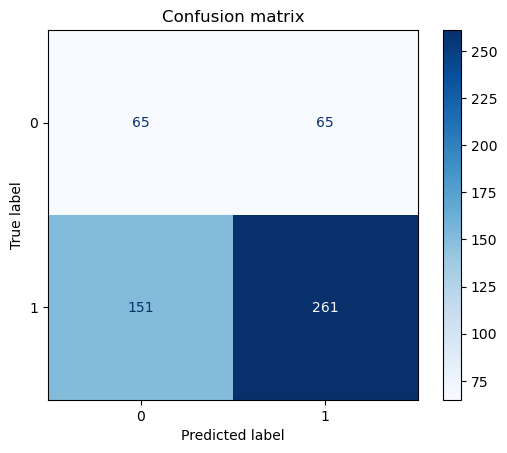

In [19]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
classifier,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()

<strong> Receiver Operator Characterisitc Curve (ROC)   </strong>

The area under the ROC curve (AUC) is
a measure of how well a model can distinguish between two classes. The ROC curve is created by
plotting the true positive rate (TPR) against the false positive rate (FPR) at various classification
thresholds.


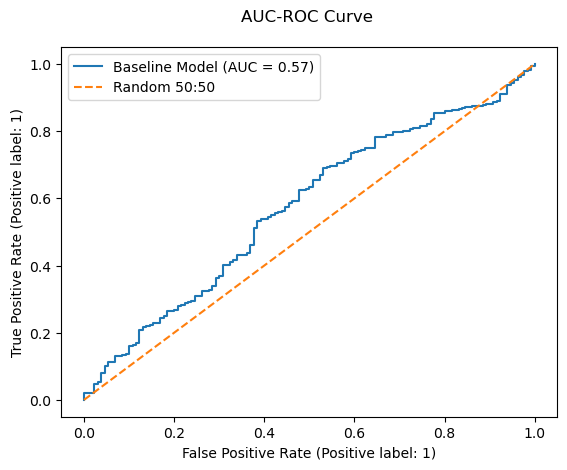

In [20]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
classifier,
X_test,
y_test,
name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

<strong> Classification Report    </strong>

A classification report is used to measure the quality of predictions from
a classification algorithm.

In [21]:
 # Classification Report
print(classification_report(y_test, classifier.predict(X_test)))


              precision    recall  f1-score   support

           0       0.30      0.50      0.38       130
           1       0.80      0.63      0.71       412

    accuracy                           0.60       542
   macro avg       0.55      0.57      0.54       542
weighted avg       0.68      0.60      0.63       542



<strong> Macro Average    </strong> Average of precision (or recall or f1-score) of different classes.

<strong> Weighted Average </strong> Actual Class1 instance * precision (or recall or f1-score) of Class1 + Actual
Class2 instance * (or recall or f1-score) of Class2.


# <strong> 5  Hyperparameter Tuning    </strong>

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they
are passed as arguments to the constructor of the estimator classes. It is possible and recommended
to search the hyper-parameter space for the best cross validation score. Any parameter provided
when constructing an estimator may be optimized in this manner.


## <strong> 5.1  Cross-validation of Time Series   </strong>

Time series data are sequential in nature and are characterised by the correlation between observations.
Classical cross-validation techniques such as KFold assume the samples are independent and
identically distributed, and would result in poor estimates when applied on time series data.
To preserve the order and have training set occur prior to the test set, we use <strong>Forward Chaining</strong>
method in which the model is initially trained and tested with the same windows size. And, for
each subsequent fold, the training window increases in size, encompassing both the previous training
data and test data. The new test window once again follows the training window but stays the
same length.
We will tune the hyperparameters to select the K-Best Neighbor by <strong>TimeSeriesSplit</strong> from scikit-learn.
This is a forward chaining cross-validation method and is a variation from the KFold. In
the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard
cross-validation methods, successive training sets are supersets of those that come before them.


In [22]:
# Get Params list
classifier.get_params()


{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [23]:
# Use Optuna for Tuning
import optuna

In [24]:
# Define Objective Function
def optimize(trial, x, y):
    # specify params range
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)
    regularization = trial.suggest_float('C', 0.001, 1, log=True)
    model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
    C=regularization,
    tol=tolerance,
    class_weight='balanced'))
    ])
    tscv = TimeSeriesSplit(n_splits=2, gap=1)
    ll = []
    for idx in tscv.split(x):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        ll.append(log_loss(ytest, preds))
    return -1.0 * np.mean(ll)

In [25]:
# Create a Study
study = optuna.create_study(
study_name='hp_lr',
direction='minimize'
)

[I 2024-05-08 10:03:52,551] A new study created in memory with name: hp_lr


In [26]:
# Specify Optimization function
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20)


[I 2024-05-08 10:03:52,610] Trial 0 finished with value: -12.627266597517762 and parameters: {'tol': 0.002008159646109991, 'C': 0.12660985767581878}. Best is trial 0 with value: -12.627266597517762.
[I 2024-05-08 10:03:52,652] Trial 1 finished with value: -12.767125562996597 and parameters: {'tol': 0.007115744529627015, 'C': 0.010603340730644088}. Best is trial 1 with value: -12.767125562996597.
[I 2024-05-08 10:03:52,688] Trial 2 finished with value: -13.106783050588055 and parameters: {'tol': 0.006611350065581924, 'C': 0.0033597630430036046}. Best is trial 2 with value: -13.106783050588055.
[I 2024-05-08 10:03:52,726] Trial 3 finished with value: -13.066823346165531 and parameters: {'tol': 0.0012640650397829746, 'C': 0.004199451819984152}. Best is trial 2 with value: -13.106783050588055.
[I 2024-05-08 10:03:52,757] Trial 4 finished with value: -13.126762902799317 and parameters: {'tol': 0.0018327854529205545, 'C': 0.001836681014130318}. Best is trial 4 with value: -13.126762902799317

In [27]:
 # Get the Best Params
print(f'Best Params: {study.best_params}, Best Value: {study.best_value}')


Best Params: {'tol': 0.0010290932744888956, 'C': 0.0010933716222503006}, Best Value: -13.226662163855629


## <strong> 5.2   Visualize Optimization   </strong>

In [28]:
 # plot Optimization History
optuna.visualization.plot_optimization_history(study)


In [29]:
# Plot Param Importances
optuna.visualization.plot_param_importances(study)


In [30]:
 # plot accuracies for each HP trail
optuna.visualization.plot_slice(study)


In [31]:
 # plot the surface
optuna.visualization.plot_contour(study, params=['tol', 'C'])


In [32]:
 # plot parallel coordinates
optuna.visualization.plot_parallel_coordinate(study)


## <strong> 5.3   Tuned Model  </strong>

We now build a tuned model with the best parameters using Pipelines. Dataset needs to be scaled
for the model to work properly and all the features should have a similar scale. The scaling can be
accomplished by using the StandardScaler.

In [33]:
# Scale and fit the model
clf = Pipeline([
("scaler", StandardScaler()),
("estimator", LogisticRegression(
tol=study.best_params['tol'],
C=study.best_params['C'],
class_weight='balanced',
))
])
clf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=0.0010933716222503006,
                                    class_weight='balanced',
                                    tol=0.0010290932744888956))])

In [34]:
# Predict Class Labels
y_pred = clf.predict(X_test)
# Predict Probabilities for upside
# y_proba = model.best_estimator_.predict_proba(X_test)[:,1]
# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t:{acc_test :0.4}')



 Training Accuracy 	: 0.585 
 Test Accuracy 		:0.6107


<strong> Confusion Matrix </strong>

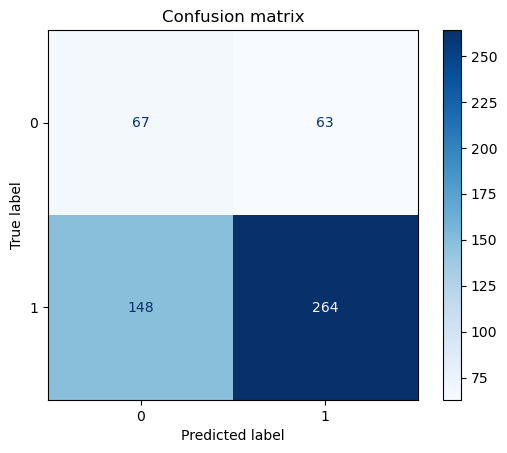

In [35]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
clf,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()


<strong> Receiver Operator Characterisitc Curve (ROC) </strong>

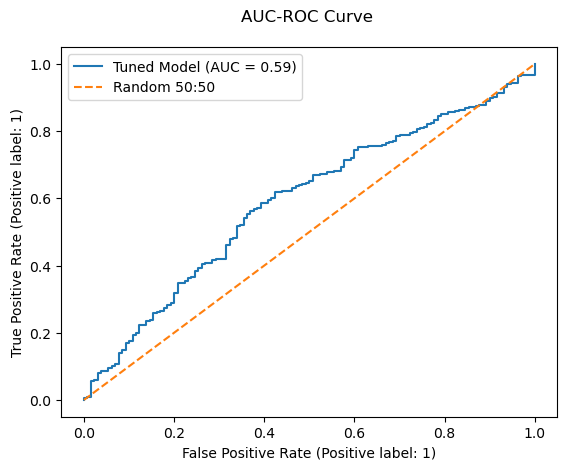

In [36]:
 # Display ROCCurve
disp = RocCurveDisplay.from_estimator(
clf,
X_test,
y_test,
name='Tuned Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()


<strong> Classification Report </strong>

In [37]:
 # Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.31      0.52      0.39       130
           1       0.81      0.64      0.71       412

    accuracy                           0.61       542
   macro avg       0.56      0.58      0.55       542
weighted avg       0.69      0.61      0.64       542



<strong> Observation</strong>

1. Accuracy, Recall and Precision improved marginally.

2. Tuning improved prediction for upside marginally

# <strong> 6 Trading Strategy </strong>

Let’s now define a trading strategy. We will use the predicted signals for trades. We then compare
the result of this strategy with the buy and hold and visualize the performance of the strategy built
using Logistic Regression

In [38]:
df2= pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/niftyindex.csv', index_col=0, parse_dates=True,dayfirst=True)
df2.head(3)

df2 = df2.iloc[13:,:]
# Get Prediction
df2['Signal'] = clf.predict(X)
# Define Entry Logic
df2['Entry'] = np.where(df2['Signal']==1, df2['Close'], 0)
# Defining Exit Logic
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) <= df2['Close']),
df['Open'].shift(-1), 0)
df2['Exit'] = np.where((df2['Entry'] != 0) & (df2['Open'].shift(-1) > df2['Close']),
df2['Close'].shift(-1), df2['Exit'])
# Calculate MTM
df2['P&L'] = df2['Exit'] - df2['Entry']
# Generate Equity Curve
df2['Equity'] = df2['P&L'].cumsum() + df2['Close'][0]
# Calculate Benchmark Return
df2['Returns'] = np.log(df2['Close']).diff().fillna(0)
# Calculate Strategy Return
df2['Strategy'] = (df2['Equity']/df2['Equity'].shift(1) - 1).fillna(0)
df2 = df2.iloc[:-1]

In [39]:
# Generate HTML Strategy Report
# Refer HTML file for report
import quantstats as qs
qs.reports.html(df2['Strategy'], df2['Returns'])


C:\Users\heidi\anaconda3\Lib\site-packages\pyfolio\pos.py:25: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



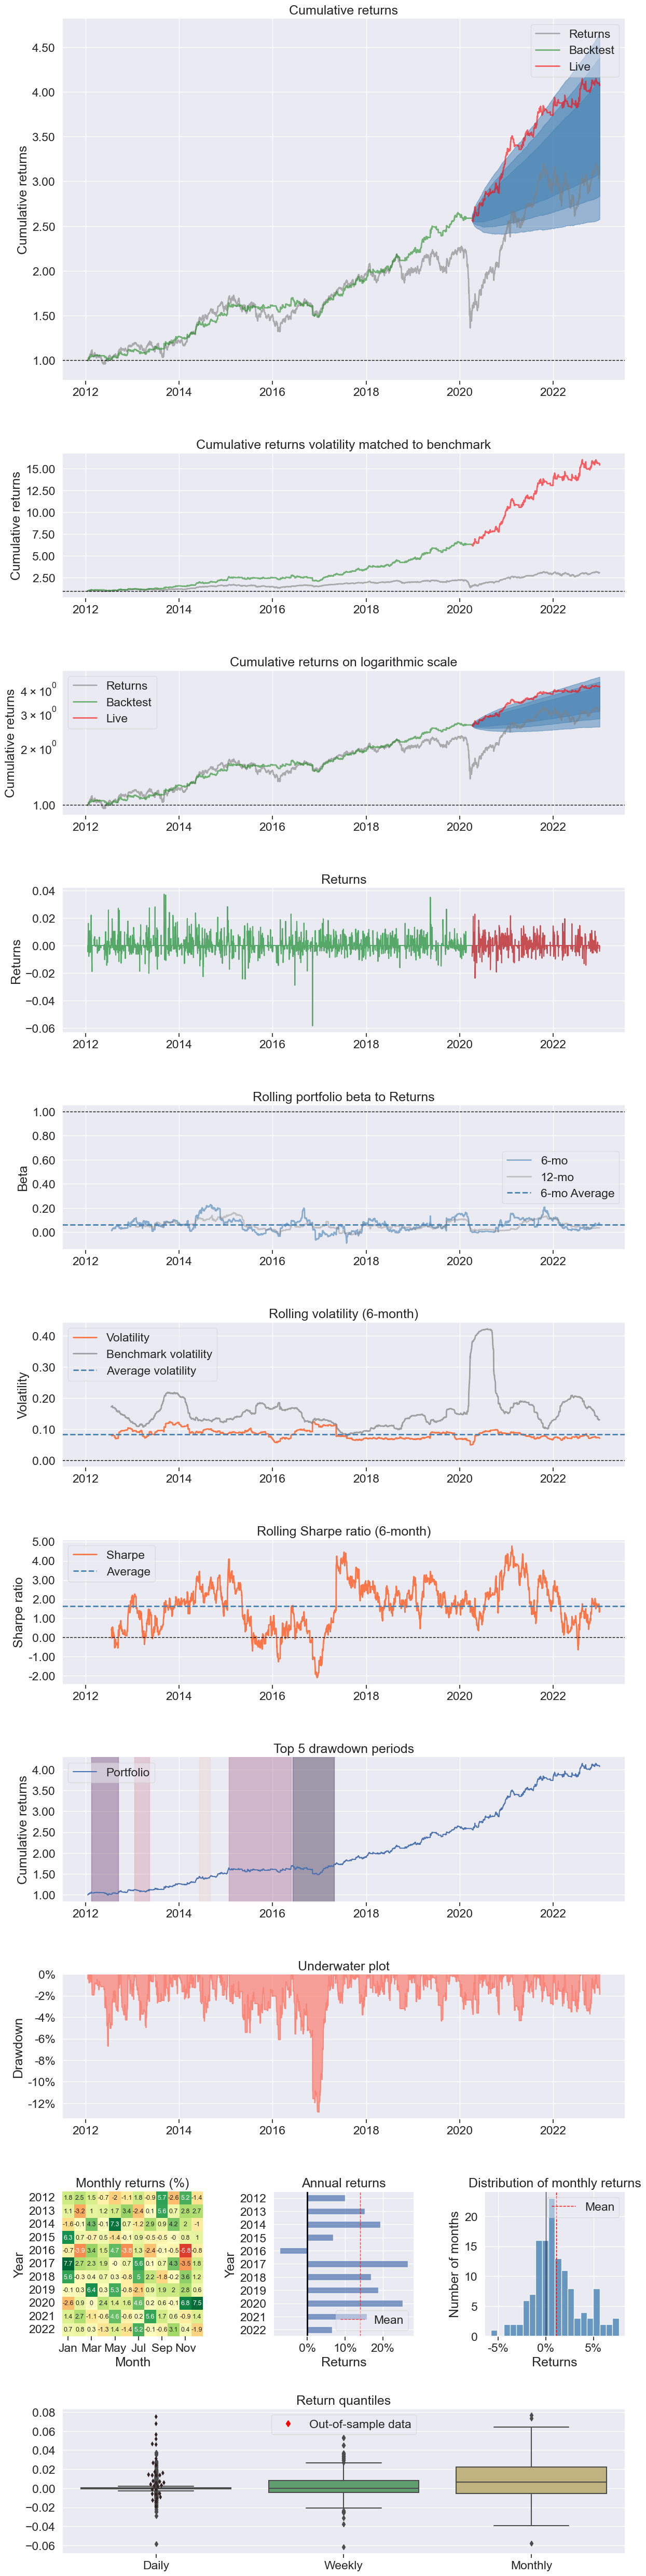

In [40]:
 # Can also use pyfolio for analysis
import pyfolio as pf
df3 = df2.copy()
df3.index = df3.index.tz_localize('utc')
pf.create_returns_tear_sheet(df3['Strategy'], live_start_date='2020-04-07',benchmark_rets=df3['Returns'])

##  <strong> 7 References </strong>

* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Hyperparameters Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


Notes 1. Sckit-learn format. One may also use a difference convention for axes

Python Labs by [Kannan Singaravelu.](https://www.linkedin.com/in/kannansi/)